In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, classification_report
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer #помогает одновременно обрабатывать и текствовые и нетекстовые признаки
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report

from nltk.tokenize import word_tokenize

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [7]:
test = pd.read_csv(r'D:\\соревнование\\test.csv')
train = pd.read_csv(r'D:\\соревнование\\train.csv', nrows=2000000)




In [18]:
train['passenger_count'].max()

5

In [23]:
train.shape

(2000000, 8)

In [3]:
missing_values = test.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0] / test.shape[0]
print(f'{missing_values * 100} %')

Series([], dtype: float64) %


In [4]:
missing_values = train.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0] / train.shape[0]
print(f'{missing_values * 100} %')

dropoff_longitude    0.0007
dropoff_latitude     0.0007
dtype: float64 %


In [8]:
from scipy import stats

def drop_outliers(dataset):
   if 'fare_amount' in dataset.columns:
      cols = ['fare_amount', 'passenger_count']
   else:
      cols = ['passenger_count']
   
   for col in cols:
      dataset = dataset[np.abs(stats.zscore(dataset[col])) < 3]

   latitude_outliers = dataset[(dataset['pickup_latitude'] < -90) | (dataset['pickup_latitude'] > 90) | (dataset['dropoff_latitude'] < -90) | (dataset['dropoff_latitude'] > 90)].index
   dataset.drop(latitude_outliers, axis=0, inplace=True)
   longitude_outliers = dataset[(dataset['pickup_longitude'] < -180) | (dataset['pickup_longitude'] > 180) | (dataset['dropoff_longitude'] < -180) | (dataset['dropoff_longitude'] > 180)].index
   dataset.drop(longitude_outliers, axis=0, inplace=True)

   return dataset
   

In [9]:
def fill_nans(dataset):
    dataset[['dropoff_longitude', 'dropoff_latitude']] = dataset[['dropoff_longitude', 'dropoff_latitude']].fillna(dataset[['dropoff_longitude', 'dropoff_latitude']].mean())
    return dataset

In [10]:
def datetime_to_columns(dataset):
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'])
    dataset['year'] = dataset['pickup_datetime'].dt.year
    dataset['month'] = dataset['pickup_datetime'].dt.month
    dataset['time'] = dataset['pickup_datetime'].dt.hour
    dataset.drop('pickup_datetime', axis=1, inplace=True)
    return dataset
 #у дней недели была нулевая корреляция с целевой


In [11]:
def distance(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    dist = 6367 * c
    return round(dist, 2)

In [13]:
def add_distance(dataset):
    dataset['distance'] = distance(dataset['pickup_latitude'].apply(lambda x: float(x)), dataset['pickup_longitude'].apply(lambda x: float(x)), dataset['dropoff_latitude'].apply(lambda x: float(x)), dataset['dropoff_longitude'].apply(lambda x: float(x)))
    dataset.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1, inplace=True)
    return dataset

In [14]:
def process_features(dataset):
    dataset = fill_nans(dataset)
    dataset = datetime_to_columns(dataset)
    dataset = drop_outliers(dataset)
    dataset = add_distance(dataset)
    return dataset

In [15]:
train = process_features(train)
#на тесте не проверила, но по идее должно работать

In [55]:
train.head()

,key,fare_amount,passenger_count,year,month,time,distance
0,2009-06-15 17:26:21.0000001,4.5,1,2009,6,17,1.03
1,2010-01-05 16:52:16.0000002,16.9,1,2010,1,16,8.44
2,2011-08-18 00:35:00.00000049,5.7,2,2011,8,0,1.39
3,2012-04-21 04:30:42.0000001,7.7,1,2012,4,4,2.80
4,2010-03-09 07:51:00.000000135,5.3,1,2010,3,7,2.00


<Axes: >

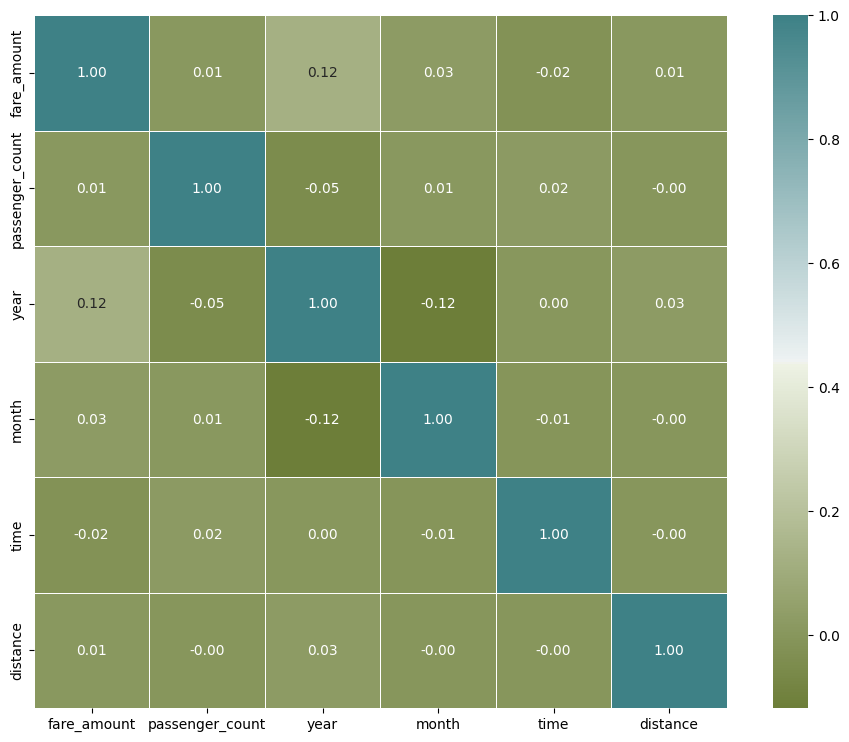

In [56]:
plt.figure(figsize=(12,9))

corr = train.drop(['key'], axis=1).corr()

sns.heatmap(corr,annot=True,linewidths=.5,fmt= '.2f',\
            mask=np.zeros_like(corr, dtype=bool), \
            cmap=sns.diverging_palette(100,200,as_cmap=True), square=True)


#надеюсь, Арина добавит красивые цвета в матрицу

Text(0, 0.5, 'Fare Amount')

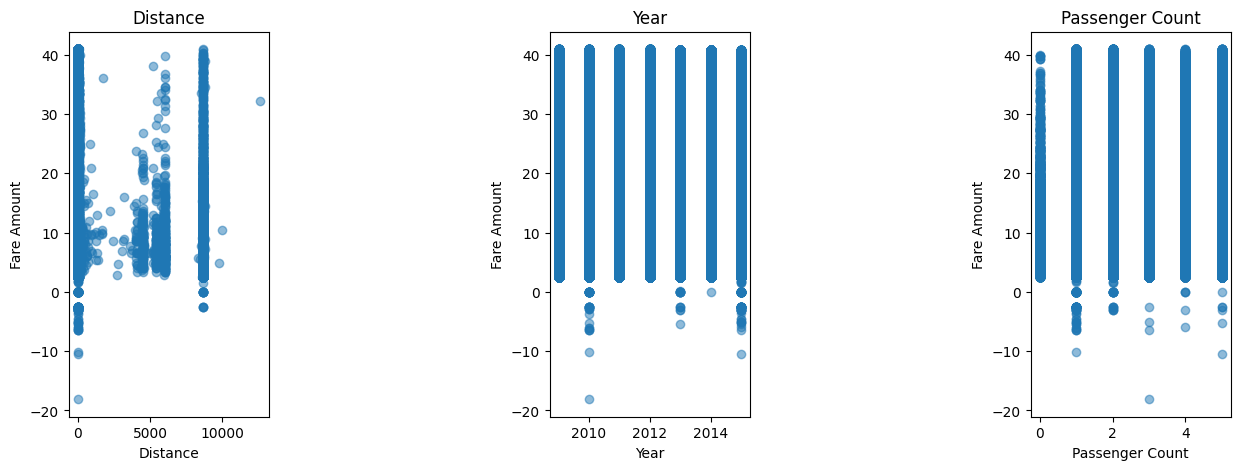

In [17]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(train['distance'], train['fare_amount'], alpha=0.5)
plt.title('Distance')
plt.xlabel('Distance')
plt.ylabel('Fare Amount')

plt.subplot(1, 3, 2)
plt.scatter(train['passenger_count'], train['fare_amount'], alpha=0.5)
plt.title('Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount')

plt.subplot(1, 3, 3)
plt.scatter(train['year'], train['fare_amount'], alpha=0.5)
plt.title('Year')
plt.xlabel('Year')
plt.ylabel('Fare Amount')


Линейная регрессия для проверки метрики

In [57]:
X = train.drop(['key', 'fare_amount'], axis=1)
y = train['fare_amount']

In [58]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

In [60]:
scaler = StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

regressor = LinearRegression()
regressor.fit(Xtrain, ytrain)

ypred_train = regressor.predict(Xtrain)
ypred_test = regressor.predict(Xtest)

print(f'Test: {mean_squared_error(ypred_test, ytest) ** 0.5}\nTrain:{mean_squared_error(ypred_train, ytrain) ** 0.5}') 

Test: 6.374634099783066
Train:6.3683395315591484
